In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install tensorflow==2.4

     |████████████████████████████████| 394.7MB 45kB/s 
     |████████████████████████████████| 471kB 34.5MB/s 
     |████████████████████████████████| 2.9MB 43.6MB/s 
     |████████████████████████████████| 3.8MB 38.2MB/s 
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


# Change working directory to project (Google Drive)

In [7]:
import os
os.chdir('/content/drive/MyDrive/projects/Tensorflow-tutorial-Daniel-Bourke/notebooks/')
os.listdir()

['07-Milestone-Project-1-Food-Vision-Big.ipynb',
 '.ipynb_checkpoints',
 '03B-10-Food-Multiclass-Classification.ipynb',
 '04-Transfer-Learning-Part1-Feature-Extraction.ipynb',
 '01A-tensorflow-neural-network-regression.ipynb',
 '01B-tensorflow-neural-network-regression.ipynb',
 '00-tensorflow-fundamentals.ipynb',
 '05-Transfer-Learning-Part2-Fine-Tuning.ipynb',
 'Z-Check-Imports.ipynb',
 '02B-Fashion-MNIST-larger-example.ipynb',
 '03A-Pizza-Steak-Image-Classification.ipynb',
 '01C-tensorflow-neural-network-regression.ipynb',
 '06-Transfer-Learning-Part3-Food-Vision-Mini.ipynb',
 '02A-tensorflow-playground-reimplementation.ipynb',
 '08-NLP-Basics-in-Tensorflow-Disaster-Tweets.ipynb']

# 07-Milestone-Project-1-Food-Vision-Big

In the previous notebook (transfer learning part 3: scaling up), we built the Food Vision Mini: a transfer learning model which beat the original results of the [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) with only 10% of the data. In this notebook, we are going to use all of the data of the Food101 dataset.
* Train: 75,750
* Test: 25,250
* Number of classes: 101


**Goal**: Beat the [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment), a 2016 paper which used a CNN trained for 2-3 days to acheive 77.4% top-1 accuracy.

> **Note**: *top-1* accuracy means "accuracy for the top softmax activation value output for the model". Hence *top-5* accuracy would just mean, if the actual class lies inside the top-5 activations, we consider it to be correct. *top-1* accuracy will always be lower than *top-5*

> **Idea**: Just like top-1, and top-n accuracy where we evaluate the prediction as correct if the true label lies in the top-n activations, can we define another performance metric, where we calculate the average n of the position of the correct label in the softmax probabilities. Lower the n, better is the model's performance.


**ADD TABLE FOR Food-Vision-Big vs Food-Vision-Mini Comparison**


Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the spped our model training:
1. Prefetching
2. Mixed precision training


Contents of the Notebook:

- [ ] Using Tensorflow datasets to download and explore the data as opposed to downloading from elsewhere and then loading. (Is there a way to dump the dataset somewhere, if the dataset is large?)
- [ ] Create preprocessing functions for our data
- [ ] Batching and preparing datasets (datasets are prefetched and preprocessed faster)
- [ ] Create modelling callbacks
- [ ] Setting up mixed precision training (requires compute capability > 7.0)
- [ ] Build a feature extraction model (transfer learning)
- [ ] Fine tune our feature extraction model
- [ ] Viewing the training results on Tensorboard

# Check the GPU

**Mixed precision training** was introduced in Tensorflow 2.4.0.

- It uses a combination of single precision (float32) and half-precision (float16) data types to speed up the training (upto 3x on modern GPUs)
- [Tensorflow documentation on mixed precision](https://www.tensorflow.org/guide/mixed_precision)
- A GPU with compute capability score of 7.0+ is required
- On Google Colab: P100 (not compatible), K80 (not compatible) and T4 GPUs (**compatible**).
- [Nvidia GPU compute capabilities](https://developer.nvidia.com/cuda-gpus#compute)


> **Note**: if you run the cell below and see a P100 or K80, go to Runtime -> Factory Reset Runtime and retry to get a T4.

In [8]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-b8b30eb1-aa56-e51a-09fd-e3b30c56f81c)


In [9]:
# Check Tensorflow version
import tensorflow as tf
print(tf.__version__)

2.4.0


## Use Tensorflow Datasets to Download Data

* In the previous notebooks, we used google storage to download the Food101 dataset. This is typically the case, that we fetch the datafiles and keep it on some kind of storage (if large, then on the cloud)
    * Then we connect, and fetch from that storage

* However, there is another way to get datasets ready to use with Tensorflow. Many popular machine learning datasets (often used for benchmarking), can be accessed through [Tensorflow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview)

What is **Tensorflow Datasets**:

Pros:

* Load data already in tensors
* Practice on well established datasets
* Experiment with different data loading techniques

Cons:
* Datasets are static (real world datasets change)
* Might not be suited for our particular problem


In [10]:
import tensorflow_datasets as tfds

In [11]:
datasets_list = tfds.list_builders()
datasets_list

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

In [12]:
print('food101' in datasets_list)

True


This means the `food101` dataset is available!

In [63]:
(train_data, test_data), ds_info = tfds.load(name='food101', 
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True, # download data in tuple format (sample, label)
                                             with_info=True)



In [14]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    version=2.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 75750,
        'validation': 25250,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      

In [15]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [16]:
# Get the class names
CLASS_NAMES = ds_info.features['label'].names
CLASS_NAMES[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 data from Tensorflow Datasets

Let us explore the following things in our data:

* The shape of our input data (image tensors)
* Datatype of the input data
* How do the labels look like (whether integers or one-hot)

In [20]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in the format (image_tensor, label)

Because we used `as_supervised=True` in `tfds.load()`, the data samples come in the tuple format structure `(data, label)` i.e. `(image_tensor, label)`

In [21]:
# Let's see how our sample data looks like
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

Let's "loop through" our single training sample and get some info from the `image_tensor` and `label`

In [22]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f'''
    Image shape: {image.shape}
    Image dtype: {image.dtype}
    Target class: {label}
    Class name: {CLASS_NAMES[label.numpy()]}
    ''')


    Image shape: (384, 512, 3)
    Image dtype: <dtype: 'uint8'>
    Target class: 97
    Class name: takoyaki
    


Because we set `shuffle_files=True` parameter in our `tfds.load()`, running above cell will result in a different result everytime. The dimensions of the images may also be different, sometimes appearing to `(512, 512, 3)` and sometimes `(512, 342, 3)`

In [23]:
# Let's check out the image tensor
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[ 54,  30,  26],
        [ 57,  33,  29],
        [ 72,  49,  43],
        ...,
        [192, 184, 163],
        [190, 179, 159],
        [181, 169, 147]],

       [[ 51,  28,  22],
        [ 60,  37,  31],
        [ 81,  58,  52],
        ...,
        [191, 183, 162],
        [189, 176, 157],
        [176, 164, 142]],

       [[ 78,  58,  49],
        [ 96,  76,  67],
        [122, 102,  93],
        ...,
        [191, 183, 162],
        [188, 175, 156],
        [172, 157, 136]],

       ...,

       [[162, 140, 117],
        [164, 142, 119],
        [169, 147, 126],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[168, 146, 123],
        [170, 148, 125],
        [176, 154, 131],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[173, 151, 128],
        [176, 154, 131],
        [182, 160, 137],
        ...,
        [  4,   4,   

In [24]:
# The min and the max values
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

The minimum and maximum are actually in the range `(0, 255)` as it is a 8 bit RGB image.

### PLot the image

(-0.5, 511.5, 383.5, -0.5)

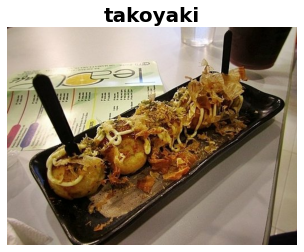

In [25]:
import matplotlib.pyplot as plt
plt.imshow(image);
plt.title(CLASS_NAMES[label.numpy()], fontdict=dict(weight='bold', size=20));
plt.axis('off')

## Create preprocessing functions for our data

In the previous notebooks, when our images were in the folder we used the method `tf.keras.preprocessing.image_dataset_from_directory()` to load them in. Doing so, we passed multiple preprocessing arguments which made our data ready to be inputted to the model.

However, since we've downloaded the data from Tensorflow Datasets, there are a few preprocessing steps we have to take before it's ready for the model.

Specifically:

* Our data is currently in `uint8` dtype
    * Convert to `float32` datatype
* Comprised of all different sized tensors (different sized images)
    * Convert to same sized tensors (batches require all tensors to have the same shape e.g. `(224, 224, 3)`)
* Not scaled (the pixel values are between 0 & 255)
    * We need to scale them to values between (0 & 1) [Normalization]. Each pixel is a feature.

To take care of these, we will create `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using `tf.image.resize()`
* Converts an input image tensor's current datatype to `tf.float32` using `tf.cast()`

> **Note**: Pretrained EfficientNetB{X} models in `tf.keras.applications` have rescaling built-in. The same models downloaded from `Tensorflow Hub` behave differently, probably because they don't have rescaling by default.  






In [26]:
# Make a function to preprocess the imag

def preprocess_image(image, label, img_size=224, dtype=tf.float32, scale=False):

    image = tf.image.resize(image, size=(img_size, img_size))
    if scale:
        image = image/255.0
    
    image = tf.cast(image, dtype)

    return image, label

* The above ``preprocess_image` function takes in an image, and resizes it, converts it into a dtype, and optionally scales it assuming a 8-bit image.

In [27]:
# preprocess a single image
preprocessed_img = preprocess_image(image, label)[0]
print(f'''Image before preprocessing:\n{image}
Shape: {image.shape}
Datatype: {image.dtype}
''')

print('-'*10, '\n')

print(f'''Image after preprocessing:\n{preprocessed_img}
Shape: {preprocessed_img.shape}
Datatype: {preprocessed_img.dtype}
''')


Image before preprocessing:
[[[ 54  30  26]
  [ 57  33  29]
  [ 72  49  43]
  ...
  [192 184 163]
  [190 179 159]
  [181 169 147]]

 [[ 51  28  22]
  [ 60  37  31]
  [ 81  58  52]
  ...
  [191 183 162]
  [189 176 157]
  [176 164 142]]

 [[ 78  58  49]
  [ 96  76  67]
  [122 102  93]
  ...
  [191 183 162]
  [188 175 156]
  [172 157 136]]

 ...

 [[162 140 117]
  [164 142 119]
  [169 147 126]
  ...
  [  5   5   5]
  [  6   6   6]
  [  6   6   6]]

 [[168 146 123]
  [170 148 125]
  [176 154 131]
  ...
  [  5   5   5]
  [  6   6   6]
  [  6   6   6]]

 [[173 151 128]
  [176 154 131]
  [182 160 137]
  ...
  [  4   4   4]
  [  6   6   6]
  [  6   6   6]]]
Shape: (384, 512, 3)
Datatype: <dtype: 'uint8'>

---------- 

Image after preprocessing:
[[[ 56.23469    32.591835   27.877552 ]
  [ 98.16328    75.16328    68.50001  ]
  [121.62245   101.62245    91.63265  ]
  ...
  [191.72456   191.36736   170.93883  ]
  [202.18863   196.9743    176.90286  ]
  [185.918     174.10167   153.6169   ]]

 [[ 9

How does the image look like after preprocessing?

* We can still plot our image, if we divide by 255. Floats between 0 and 1 are interpreted as RGB intensities

(-0.5, 223.5, 223.5, -0.5)

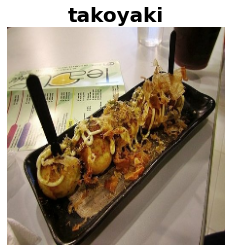

In [28]:
plt.imshow(preprocessed_img/255.);
plt.title(CLASS_NAMES[label.numpy()], fontdict=dict(weight='bold', size=20));
plt.axis('off')

In [53]:
len(train_data), len(test_data)

(75750, 25250)

## Batch and prepare datasets
* Before we can model our data, we have to turn it into batches. This is because computing on batches is memory efficient, more gradient descent steps, faster training.

* Essentially, we have to convert our 75750 (train), and 25250 (test) images into batches of size 32 [Friends don't let friends use minibatch sizes larger than 32](https://twitter.com/ylecun/status/989610208497360896?lang=en)

* To do this in the most efficient way, we will use the `tf.Data` API. See [Better performance with the tf.Data API](https://www.tensorflow.org/guide/data_performance)

Specifically, we're going to be using:

* `map()` - maps a predefined function to a target dataset (e.g. we will map `preprocess_image` to our image tensors). Resizing is the most essential function here, as the images need to be of the same size to be batched later.
* `shuffle()` - randomly shuffles elements of the target dataset up to the `buffer_size`. Ideally, `buffer_size` must be equal to the size of the dataset, but if the training set is large, the buffer might not fit in the memory. A fairly large number of 1000, or 10000 is usually sufficient for shuffling.
* `batch()` - turns elements of the target dataset into batches (size defined by `batch_size` parameter)
* `prefetch()` - prepares subsequent batches of data whilst other batches of data are being computed on (i.e. as the model is training, simultaneously upcoming batches are being prepared)


Things to note:

* For methods with `num_parallel_calls` argument, set it to `tf.data.AUTOTUNE`. This will parellelize preprocessing and significantly improve speed.
* Can't use `cache()` unless the dataset fits in the memory


We are going to do the things in the following order:

    Original dataset -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchedDataset

In words this will sound like:
> We first map the preprocessing function accross our training dataset, then shuffle a number of elements before batching, and make sure you prepare the new batches whist the model is training through the current batch


![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-prefetching-from-hands-on-ml.png)

Source: Page 422 [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron.](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

Now let us carry out the above steps on both `train` and `test` data

In [64]:
# Map the preprocessing function to training data (and parellelize)
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (prepare beforehand/keep preparing -> load in memory for faster fetching)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [65]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

* Now our data is in tuples of `(image, label)` with datatypes of `(tf.float32, tf.int64)`. This is why we added a redundant argument `label` into our `preprocess_img` function.
* We could have done this without using the `prefetch()` argument, however the we would see significantly slower data loading speeds when building a model. So most of the data pipelines should end with a call to `prefetch()`

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long amount of time, it's a good idea to setup some modelling callbacks to be sure of mainly two things:

* That we are tracking our model's training logs -> `tf.keras.callbacks.TensorBoard()`
* That our model is being checkpointed (weights saved after various training milestones) -> `tf.keras.callbacks.ModelCheckpoint()`
    * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits



In [66]:
from src.evaluate import KerasMetrics

In [94]:
TASK = '101_food_multiclass_classification'

In [95]:
checkpoint_path = f'../checkpoints/{TASK}/efficientnetb0_feature_extract_all_data/efficientnetb0_feature_extract_all_data.ckpt'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                      monitor='val_accuracy', # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0)


## Setup mixed precision training

* Normally, tensors in Tensorflow default to float32 datatype (unless otherwise specified). 
* float32 is also known as single-precision-floating-point-format. The 32 means it usually occupies 32 bits in computer memory.
* The GPU has limited memory, therefore it can only handle a number of float32 tensors at the same time.
* This is where mixed precision training comes in. Mixed precision training involves a mix of float16 and float32 tensors to make better use of the GPUs memory.
* float16 means half-precision-floating-point-format. So tensors in 16 bit occupy 16bit in memory.

So if we use mixed precision training, the model will make use of float32 and float16 data types to use less memory wherever possible, and hence run faster (using less memory per tensor means more tensors can be computed on simultaneously)

This makes the performance of modern GPUs (with compute capability score of 7.0+) upto 3x faster. Read [Tensorflow mixed precision guide](https://www.tensorflow.org/guide/mixed_precision)

In [68]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16')

In [69]:
mixed_precision.global_policy()

<Policy "mixed_float16">

Since the global policy is set to `mixed_float16` our model will automatically take advantage of float15 variables where possible and in turn speed up training. 

## Build feature extraction model

* Callbacks: `TensorBoard` and `ModelCheckpoint`
* `MixedPrecision` training
* Feature extraction from `EfficientNetB0`


To build the feature extraction model we will:

* Use `EfficientNetB0` from `tf.keras.applications`. This is pretrained on ImageNet.
    * Since our output shape i.e. number of prediction classes are different, we will use `include_top=False`
* We will not train/tune the weights of this model and hence will set it `trainable=False`
* The downstream model will be created using the Keras FUnctional API.
* Optimizer = `Adam`, and `sparse categorical entropy` as the loss function (since our varaibles are not one-hot encoded)


> **Note**: Since we're using mixed precision training, our model needs a separate Activation layer with hardcoded `dtype=float32`. This ensures the outputs of our model are returned as `float32` which are more numerically stable than `float16` datatype (important for loss calculations). 

In [70]:
N_CLASSES = len(CLASS_NAMES)
N_CLASSES

101

In [71]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing as KerasPreprocessing


In [98]:
model_name = 'efficientnetb0_feature_extract'

In [77]:
# Create the base pretrained model
pretrained_model = tf.keras.applications.EfficientNetB0(include_top=False)
pretrained_model.trainable = False

# Create the downstream model
input_shape = (224, 224, 3)
inputs = layers.Input(shape=input_shape, name='input_layer')
features = pretrained_model(inputs)
pooled = layers.GlobalAveragePooling2D(name='pooling_layer')(features)
outputs = layers.Dense(N_CLASSES)(pooled)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(outputs)

# Final model
model = tf.keras.models.Model(inputs, outputs, name=model_name)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Summary
model.summary()


Model: "efficientnetb0_feature_extract"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Checking layer dtype policies

In [78]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_5 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


> **Note**: A layer can have a dtype of `float32` and a dtype policy of `mixed_float16` because it store its variables (weights and biases) in `float32` (more numerically stable) but it computes in `float16` (faster)

Checking for the `pretrained_model`

In [74]:
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_7 False float32 <Policy "float32">
rescaling_6 False float32 <Policy "mixed_float16">
normalization_6 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float

The mixed precision API automatically causes layers which can benefit from using the `mixed_float16` dtype policy to use it. It also prevents layers which shouldn't use it from using it (e.g. the normalization layer at the start of the base model)

## Fit the feature extraction model


In [92]:
from src.utils import create_tensorboard_callback
from src.visualize import plot_learning_curve
from src.utils import reshape_classification_prediction

In [96]:
history = model.fit(train_data,
                    epochs=3,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data, # Just using it to monitor, o.w. the purpose of validation and test data is different.
                    validation_steps=len(test_data), 
                    callbacks=[create_tensorboard_callback(experiment='efficientnetb0_feature_extract_all_data', task='101_food_multiclass_classification',
                                                           parent_dir='../tensorboard_logs/'), model_checkpoint])

Saving TensorBoard log files to " ../tensorboard_logs/101_food_multiclass_classification/efficientnetb0_feature_extract_all_data/20210618-182607"
Epoch 1/3
2368/2368 [==============================] - 190s 80ms/step - loss: 0.9825 - accuracy: 0.7374 - val_loss: 1.0515 - val_accuracy: 0.7172
Epoch 2/3
2368/2368 [==============================] - 188s 79ms/step - loss: 0.9491 - accuracy: 0.7466 - val_loss: 1.0560 - val_accuracy: 0.7146
Epoch 3/3
2368/2368 [==============================] - 192s 80ms/step - loss: 0.9146 - accuracy: 0.7537 - val_loss: 1.0634 - val_accuracy: 0.7133


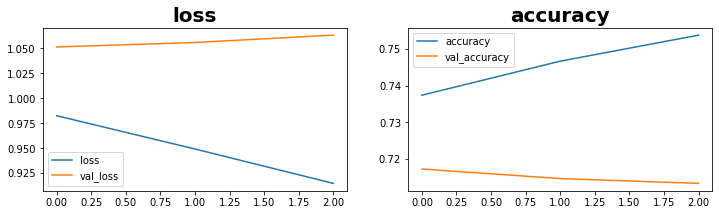

In [97]:
plot_learning_curve(history, extra_metric='accuracy');

The model keeps on fitting the training set very well, but does not really improve on the validation set. Definitely overfitted, and doesn't seem to learn patterns in a meaningful way.

In [100]:
PREDICTIONS = {}

PREDICTIONS[model_name] = {}

for data, subset in zip([train_data, test_data], ['train', 'test']):
    PREDICTIONS[model_name][subset] = reshape_classification_prediction(model.predict(data, verbose=1))


790/790 [==============================] - 47s 58ms/step


## Load and evaluate the checkpoint weights

We can load the model's checkpoints by:

1. Clone our model (or make exactly same new one)
2. Calling `load_weights` method on our cloned model and passing the path to the checkpointed weights

In [103]:
cloned_model = tf.keras.models.clone_model(model)
cloned_model.load_weights(checkpoint_path)

In [104]:
# Need to recompile the model
cloned_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [107]:
from src.utils import check_tfmodel_weights_equality

check_tfmodel_weights_equality(model, cloned_model) # Umm whaaaaaaat? 

False

## Save the whole models to file


In [110]:
save_dir = r'../models/101_food_multiclass_classification/efficientnetb0_feature_extraction_all_data'
model.save(save_dir)

In [113]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

## Preparing our model's layers for fine-tuning

Our model was giving good results with just 3 epochs of training. But since we have go so much data, we can probably go ahead and fine-tune the weights of the entire model including the pretrained base model.

Our goal is to beat the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf) with top-1 accuracy of 77.4% accuracy. Their model was trained for 2-3 days.

## Some more callbacks

We are about to start training a deep learning models with 200 layers with over 100,000 data points (train: 75k+, test: 25k+), which means our model training is going to be much longer than before.

> **Question:** How long will the training take?

Train it for one epoch. Multiply by the number of epochs you desire to train.

> **Question:** When to stop the training?

* Ideally, when the model stops improving. We can constantly monitor the performance of the model, and see if it is improving epoch by epoch. When it ceases to learn much, we can stop the training. This can be achieved using `EarlyStopping` callback which monitors a specific model performance metric (e.g. `val_loss`).

* Using the `EarlyStopping` callback combined with the `ModelCheckpoint` callback will save the best performing model automatically. We could keep our model training for an unlimited number of epochs until it stops improving.




In [114]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # Don't monitor val_accuracy as it is not a continous metric and will induce noise
                                                  patience=3 # if val_loss does not decrease in a row, stop training
                                                  )


checkpoint_path = '../checkpoints/101_food_multiclass_classification/efficientnetb0_fine_tune_all_data/efficientnetb0_fine_tune_all_data.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')

* There is one more callback that we will implement: `ReduceLROnPleateau`. 
* Learning rate is the most important hyperparameter that you can tune.
* `ReduceLRonPlateau` helps you tune the learning rate.
* Like the `ModelCheckpoint` and `EarlyStopping` callbacks, the `ReduceLROnPlateau` callback monitors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (for e.g. reduce the learning rate by a factor of 10)

> **Question**: Why lower the learning rate?

Because as the model gets closer and closer to optimum (i.e. convergence), we want to learn slower and slower and get as close to the optimum as possible. Having a larger learning rate even close to the optimum can make the gradient steps noisy and can ultimately even make performance worse with each epoch.

* Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5.
* To make sure the learning rate doesn't get too low, we will set the minimum learning rate to `1e-7`

In [116]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2, # multiply the learning rate by 0.2 i.e. reduce by 5x
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7
                                                 )

Since we are fine tuning now, we'll use a 10x lower learning rate than the Adam optimizers default (`1e-4` instead of `1e-3`)

Set all the layers as trainable. This will set all the layers in the base pretrained model to trainable as well. No need to separately make them trainable.

In [123]:
for layer in model.layers:
    layer.trainable = True

In [124]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [125]:
tboard_callback = create_tensorboard_callback('efficientnetb0_fine_tune_all_data', TASK, '../tensorboard_logs/')
history = model.fit(train_data,
                    epochs=100,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    callbacks=[tboard_callback, # track the training logs
                               model_checkpoint, # save only the best model during training
                               early_stopping, # stop model after {patience} epochs of no improvements
                               reduce_lr] # reduce the learning rate after {patience} epochs of no improvements (NOTE: different patience)
                    )

Saving TensorBoard log files to " ../tensorboard_logs/101_food_multiclass_classification/efficientnetb0_fine_tune_all_data/20210618-200718"
Epoch 1/100
2368/2368 [==============================] - 220s 87ms/step - loss: 1.5643 - accuracy: 0.6024 - val_loss: 0.7749 - val_accuracy: 0.7815
INFO:tensorflow:Assets written to: ../checkpoints/101_food_multiclass_classification/efficientnetb0_fine_tune_all_data/efficientnetb0_fine_tune_all_data.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/101_food_multiclass_classification/efficientnetb0_fine_tune_all_data/efficientnetb0_fine_tune_all_data.ckpt/assets


Epoch 2/100
2368/2368 [==============================] - 205s 86ms/step - loss: 0.6986 - accuracy: 0.8089 - val_loss: 0.7284 - val_accuracy: 0.7961
INFO:tensorflow:Assets written to: ../checkpoints/101_food_multiclass_classification/efficientnetb0_fine_tune_all_data/efficientnetb0_fine_tune_all_data.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/101_food_multiclass_classification/efficientnetb0_fine_tune_all_data/efficientnetb0_fine_tune_all_data.ckpt/assets


Epoch 3/100
2368/2368 [==============================] - 205s 86ms/step - loss: 0.4597 - accuracy: 0.8748 - val_loss: 0.7060 - val_accuracy: 0.8091
INFO:tensorflow:Assets written to: ../checkpoints/101_food_multiclass_classification/efficientnetb0_fine_tune_all_data/efficientnetb0_fine_tune_all_data.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/101_food_multiclass_classification/efficientnetb0_fine_tune_all_data/efficientnetb0_fine_tune_all_data.ckpt/assets


Epoch 4/100
2368/2368 [==============================] - 206s 86ms/step - loss: 0.3315 - accuracy: 0.9077 - val_loss: 0.6875 - val_accuracy: 0.8178
INFO:tensorflow:Assets written to: ../checkpoints/101_food_multiclass_classification/efficientnetb0_fine_tune_all_data/efficientnetb0_fine_tune_all_data.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/101_food_multiclass_classification/efficientnetb0_fine_tune_all_data/efficientnetb0_fine_tune_all_data.ckpt/assets


Epoch 5/100
2368/2368 [==============================] - 205s 86ms/step - loss: 0.2287 - accuracy: 0.9387 - val_loss: 0.7080 - val_accuracy: 0.8175
Epoch 6/100
2368/2368 [==============================] - 206s 86ms/step - loss: 0.1637 - accuracy: 0.9586 - val_loss: 0.7074 - val_accuracy: 0.8091

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 7/100
2368/2368 [==============================] - 206s 86ms/step - loss: 0.1100 - accuracy: 0.9745 - val_loss: 0.7028 - val_accuracy: 0.8239


In [126]:
model.evaluate(test_data)

790/790 [==============================] - 48s 59ms/step - loss: 0.6985 - accuracy: 0.8234


[0.6984655857086182, 0.8233663439750671]

YES! We beat the DeepFood paper with just 3 + 7 epochs of training leveraging the power of transfer learning. 

* Other things to try include trying a larger model such as `EfficientNetB4`. The family of [EfficientNet models have State of the art results on the Food101 dataset](https://paperswithcode.com/sota/fine-grained-image-classification-on-food-101).

* To see the leaderboard of performance of various models in a research task (on any given dataset or problem type), check out [paperswithcode.com](paperswithcode.com) and [sotabench.com](sotabench.com)

In [134]:
model.save('../models/101_food_multiclass_classification/efficientnetb0_fine_tune_all_data/')

INFO:tensorflow:Assets written to: ../models/101_food_multiclass_classification/efficientnetb0_fine_tune_all_data/assets


INFO:tensorflow:Assets written to: ../models/101_food_multiclass_classification/efficientnetb0_fine_tune_all_data/assets


## Viewing training results on TensorBoard

In [133]:
!tensorboard dev upload --logdir ../tensorboard_logs/101_food_multiclass_classification \
--name 'EfficientNetB0 on all Food101 data' \
--description 'Training results for fine-tuning EfficientNetB0' \
--one_shot


2021-06-18 20:45:59.171721: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

../tensorboard_logs/101_food_multiclass_classification

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&red